In [1]:
%matplotlib inline

In [102]:
import glob
import numpy as np
import pylab as pl

from scipy.signal import medfilt

from astropy import modeling as mod

import ccdproc

#perform phometry on the image
import sep


In [10]:
def level_image(ccd, axis=0, order=7):
    """Take the median of the image along an axis and then fit a polynomial to 
    the distribution
    """
    nccd = ccd.copy()
    p_mod = mod.models.Polynomial1D(order)
    l = np.median(nccd.data, axis=axis)
    x = np.arange(len(l))
    fitter = mod.fitting.LinearLSQFitter()
    p = fitter(p_mod, x, l)
    if axis==1:
        nccd.data = nccd.data / p(x)[:,np.newaxis] * p(x).mean()
    else:
        nccd.data = nccd.data / p(x) * p(x).mean()
    return nccd

In [95]:
def reduce_pol_image(ccd, mflat_u, mflat_e, order=7):
    """For an image, first separate into two beams, divide through by flat and then 
    normalize the image by its shape
    """
    #trim the images
    ccd_e = ccdproc.trim_image(ccd[70:940, 1080:2090])
    ccd_u = ccdproc.trim_image(ccd[1022:1963, 1080:2090])
    
    #divide the images
    ccd_e.data = ccd_e.data / mflat_e.data
    ccd_u.data = ccd_u.data / mflat_u.data
    
    # remove structure in image
    #ccd_e = level_image(ccd_e, axis=1, order=order)
    #ccd_u = level_image(ccd_u, axis=1, order=order)
    #ccd_e = level_image(ccd_e, axis=0, order=order)
    #ccd_u = level_image(ccd_u, axis=0, order=order)
    
    return ccd_u, ccd_e

In [96]:
mflat_u = ccdproc.CCDData.read('FLAT_6645_u.fits', unit='electron')
mflat_e = ccdproc.CCDData.read('FLAT_6645_e.fits', unit='electron')


INFO: using the unit electron passed to the FITS reader instead of the unit electron in the FITS file. [ccdproc.ccddata]
INFO: using the unit electron passed to the FITS reader instead of the unit electron in the FITS file. [ccdproc.ccddata]


In [130]:
# reduce observations
image_list = glob.glob("mfxgbpP2016122000*")
ccdu_list = []
ccde_list = []

for image in image_list:
    print(image)
    ccd=ccdproc.CCDData.read(image, unit='electron')
    ccd_u, ccd_e = reduce_pol_image(ccd, mflat_u, mflat_e, order=7)
    ccdu_list.append(ccd_u)
    ccde_list.append(ccd_e)



mfxgbpP201612200042.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200043.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200044.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200045.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200081.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200082.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200083.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]
mfxgbpP201612200084.fits
INFO: first HDU with data is extension 1. [ccdproc.ccddata]


In [131]:
ccde_list[0].write('tmpe.fits', clobber=True)

In [132]:
ccdu_list[0].write('tmpu.fits', clobber=True)

In [133]:
def do_phot(ccd, ap_size=5):
    """Perform photometry on a frame and return a list of objects and fluxes
    
    """
    data = ccd.data
    bkg = sep.Background(data)
    data_sub = data - bkg
    
    objects = sep.extract(data_sub, 2, err=bkg.globalrms)
    
    flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     ap_size, err=bkg.globalrms, gain=1.0)
    return objects, flux, fluxerr, flag
    

In [134]:
def compare_phot(ccdu, ccde, ap_size=10, x0=729, y0=550):
    """Perform photometry on both images and take a look 
    """
    
    # do the photometry 
    obju, fluxu, erru, flagu = do_phot(ccdu, ap_size=ap_size)
    obje, fluxe, erre, flage = do_phot(ccde, ap_size=ap_size)
    
    # match all sources
    fluxm = fluxu * 0.0
    errm = erru * 0.0
    for i in range(len(obju)): 
        d = ((obje['x']-obju['x'][i])**2+(obje['y']-obju['y'][i])**2)**0.5
        j = d.argmin()
        fluxm[i] = fluxe[j]
        errm[i] = erre[j]
    return obju, fluxu, fluxm, erru, errm

In [135]:
def calc_raw(ccdu, ccde, x0, y0, ap_size=10):
    obj, fluxu, fluxe, erru, erre = compare_phot(ccdu, ccde, ap_size=ap_size)  
    
    # calculate the values
    x, y, r, mu, me = calc_pol(obj, fluxu, fluxe, erru, erre)
    
    #extract the source of interest
    d = ((x- x0)**2+(y-y0)**2)**0.5
    k = d.argmin()
    print(mu[k], me[k])
    return ccdu.header['HWP-ANG'], r[d.argmin()]
    

In [136]:
def with_reject(p_init, x, y, sigma=3, niter=5):
    mask = np.ones_like(x, dtype=int)
    for i in range(niter):
        p = fitter(p_init, x[mask], y[mask])
        s = y - p(x)
        mask = (abs(s) < 3*s.std())
    return p

In [137]:
def calc_pol(obj, fluxu, fluxe, erru, erre, a=1, b=1):
    mask = (obj['y']<700) * (np.log10(fluxu) > 3.2)
    r = (fluxu[mask]-a*fluxe[mask])/(fluxu[mask]+fluxe[mask])
    y = obj['y'][mask]
    x = obj['x'][mask]
    mu = np.log10(fluxu[mask])
    me = np.log10(fluxe[mask])
    
    #correct for y-residual
    #p_init = mod.models.Polynomial1D(1)
    #p = with_reject(p_init, y, r, sigma=3, niter=5)
    #r = r - p(y)
    
    return x, y, r, mu, me

In [138]:
fitter = mod.fitting.LinearLSQFitter()
q = 1
calc_raw(ccdu_list[q], ccde_list[q], 856, 530)

(3.4093479807164107, 3.4425483349729542)


(45.0, -0.038204716228816819)

  Qtot_I_39 = flux3_39[0]+ flux3_39[1] # 
  
  Utot_I_41 = flux3_41[0]+ flux3_41[1]
  
  ax9.errorbar((flux3_39[0]-flux3_39[1])/Qtot_I_39,(flux3_41[0]-flux3_41[1])/Utot_I_41,     xerr=math.sqrt( math.pow(err1_39[0],2)+math.pow(err1_39[1],2))/Qtot_I_39,  yerr=math.sqrt( math.pow(err1_41[0],2)+math.pow(err1_41[1],2))/Utot_I_41,   fmt='o',color="blue")

  print 'target percent polarized = ',  (  sqrt( math.pow((flux3_39[0]-flux3_39[1])/Qtot_I_39,2) + math.pow((flux3_41[0]-flux3_41[1])/Utot_I_41,2) )     ) *100

(3.5161772557987336, 3.5810961154552907)
(3.5437740117773711, 3.5465918630251378)
(3.5441924180864524, 3.5843783273758185)
(3.5298671814762868, 3.5463772521500387)
[0, 45.0, 22.5, 67.5]
[-0.074601738608757864, -0.0032441597574881563, -0.046232755189533889, -0.019005632445498931]
0.0877660928597
0.0463464370254
0.0192805248161


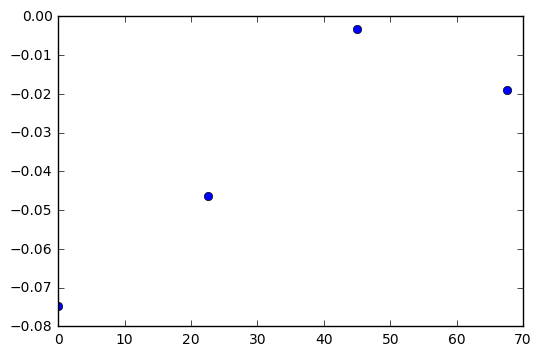

In [139]:
#unpolorized standard
s_ang = []
unpol = []
for q in range(len(image_list[:4])):
    s, p = calc_raw(ccdu_list[q], ccde_list[q], 485, 491, ap_size=10)
    s_ang.append(s)
    unpol.append(p)
print(s_ang)
print(unpol)
print((unpol[0]**2 + unpol[2]**2)**0.5)
print((unpol[1]**2 + unpol[2]**2)**0.5)
print((unpol[1]**2 + unpol[3]**2)**0.5)

pl.plot(s_ang, unpol, ls='', marker='o')

(4.450484543427903, 4.4492718853215978)
(4.4417133582048605, 4.4369517921573829)
(4.4425336282273644, 4.4678797837924131)
(4.4368902835565711, 4.4102852936094177)
[0, 45.0, 22.5, 67.5]
[0.0013961233321476204, 0.0054819005864982367, -0.029172560101128304, 0.030620551110138602]
0.0292059484217
0.0296831517345
0.0311073847234


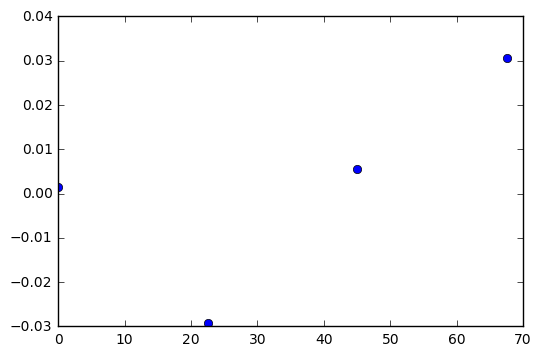

In [140]:
#polarize standard
s_ang = []
pol = []
for q in range(4, 4+len(image_list[4:])):
    s, p = calc_raw(ccdu_list[q], ccde_list[q], 485, 491, ap_size=10)
    s_ang.append(s)
    pol.append(p)
print(s_ang)
print(pol)
print((pol[0]**2 + pol[2]**2)**0.5)
print((pol[1]**2 + pol[2]**2)**0.5)
print((pol[1]**2 + pol[3]**2)**0.5)

pl.plot(s_ang, pol, ls='', marker='o')

8.40344476894
-12.6020996834
10.7337050615


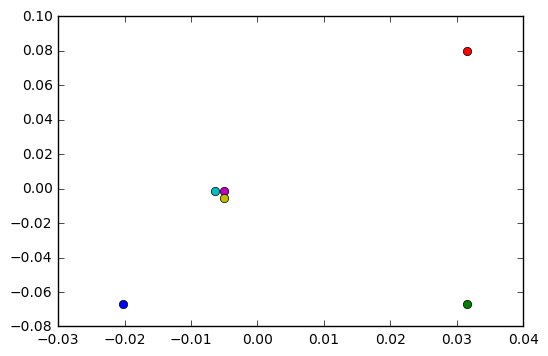

In [129]:
pl.plot(pol[0], pol[2], ls='', marker='o')
pl.plot(pol[1], pol[2], ls='', marker='o')
pl.plot(pol[1], pol[3], ls='', marker='o')
pl.plot(unpol[0], unpol[2], ls='', marker='o')
pl.plot(unpol[1], unpol[2], ls='', marker='o')
pl.plot(unpol[1], unpol[3], ls='', marker='o')

#theta = 0.5 * arctan(U/Q)
print(0.5*np.arctan(pol[0]/pol[2])*180/np.pi)
print(0.5*np.arctan(pol[1]/pol[2])*180/np.pi)
print(0.5*np.arctan(pol[1]/pol[3])*180/np.pi)


In [ ]:
(pol[1]**2 + pol[3]**2)**0.5

In [100]:
obj0, fluxu0, fluxe0, erru0, erre0 = compare_phot(ccdu_list[0], ccde_list[0])
obj1, fluxu1, fluxe1, erru1, erre1 = compare_phot(ccdu_list[1], ccde_list[1])
obj2, fluxu2, fluxe2, erru2, erre2 = compare_phot(ccdu_list[2], ccde_list[2])
obj3, fluxu3, fluxe3, erru3, erre3 = compare_phot(ccdu_list[3], ccde_list[3])



In [158]:
x0, y0, r0, mu0, me0 = calc_pol(obj0, fluxu0, fluxe0, erru0, erre0)
x1, y1, r1, mu1, me1 = calc_pol(obj1, fluxu1, fluxe1, erru1, erre1)
x2, y2, r2, mu2, me2 = calc_pol(obj2, fluxu2, fluxe2, erru2, erre2)
x3, y3, r3, mu3, me3 = calc_pol(obj3, fluxu3, fluxe3, erru3, erre3)

In [159]:
#match the sources
#source of interest lies at 856, 530
u = []
q = []
for i in range(len(x3)):
    d = ((x2-x3[i])**2+(y2-y3[i])**2)**0.5
    j = d.argmin()
    if d.min() < 3:
        u.append(r2[j])
        q.append(r3[i])
    d = ((x3[i]-856)**2+(y3[i]-530)**2)**0.5
    if d < 3:
        uu, qu = [r2[j], r3[i]]

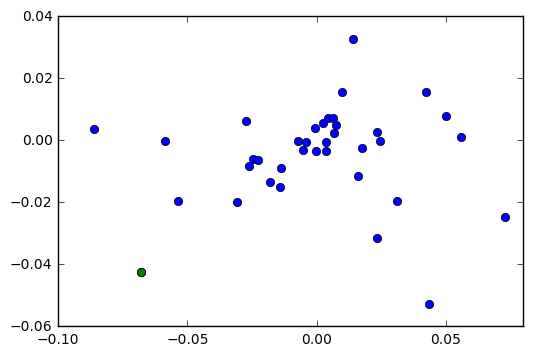

In [160]:
pl.plot(q, u, ls='', marker='o')
pl.plot([qu], [uu], ls='', marker='o')


In [77]:
mask = (obj['y']<700) * (np.log10(fluxu) > 3.2)
r = (fluxu[mask]-fluxe[mask])/(fluxu[mask]+fluxe[mask])
y = obj['y'][mask]
x = obj['x'][mask]
m = np.log10(fluxu[mask])
me = np.log10(fluxe[mask])
r.mean()

-0.073195222211717634

In [79]:
p_init = mod.models.Polynomial1D(1)
p = with_reject(p_init, y, r, sigma=3, niter=5)

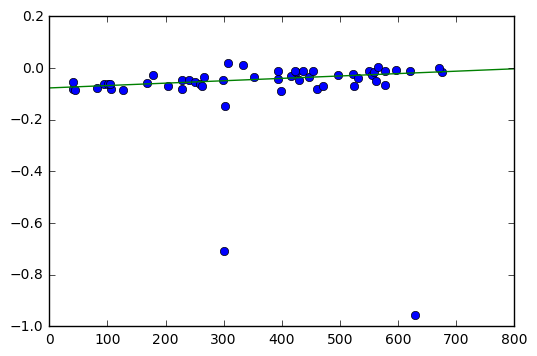

In [80]:
pl.plot(y, r, ls='', marker='o')
yarr = np.arange(800)
pl.plot(yarr, p(yarr))



In [81]:
r = r  - p(y)

In [82]:
r.mean()

-0.030135261079237783

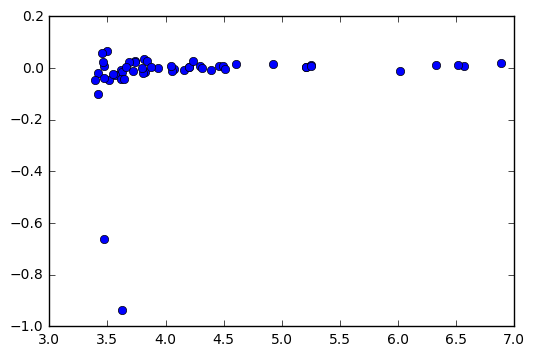

In [83]:
pl.plot(m , r, ls='', marker='o')


In [430]:
for i in range(len(fluxu)):
    print('{} {} {} {} {}'.format(i, x[i], y[i], m[i], r[i]))

0 24.0590509552 58.5221682438 3.51756222382 0.00266997330126
1 48.8401910471 61.0368172864 3.58931152193 0.0288364310839
2 -116.363602338 100.262073209 4.1010342955 0.0415444356307
3 227.069538013 110.631269307 4.39659997475 0.0539745510198
4 472.312162839 122.970774877 3.74015893196 0.0242784362831
5 726.946847934 57.6238758622 6.92014797066 0.136376237544
6 278.928250105 117.234409349 5.14511516385 0.0509214265927
7 82.6209825625 121.343127011 6.51533542234 0.0553989765883
8 138.413812893 185.145723989 4.15048715336 0.0468947410989
9 479.170308751 194.608420536 3.74421932229 0.0421338488708
10 863.309574746 214.04837054 3.29830903644 -0.878178536896
11 743.118441336 219.901648987 5.94908546173 0.0366961240385
12 83.828469209 245.075872885 4.25464142335 0.04538618954
13 286.379666124 267.207172029 3.87752596576 0.0123039401205
14 744.222596776 278.919785427 3.74229728377 0.0243955123338
15 41.9856402438 277.749106304 4.32981724105 0.00835736250562
16 255.464702078 283.761559998 4.5494

IndexError: index 42 is out of bounds for axis 0 with size 42

In [434]:
s_ang = [0, 45, 45, 0, 45, 45, 67.5]
pol = [-0.01, 0.041, -0.033, 0.030, 0.04, 0.02614, -0.0678 ]

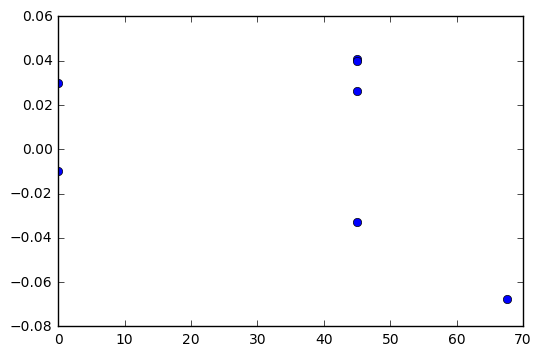

In [435]:
pl.plot(s_ang, pol, ls='', marker='o')

In [164]:
objects, flux, fluxerr, flag = do_phot(ccdu_list[0], ap_size=5)

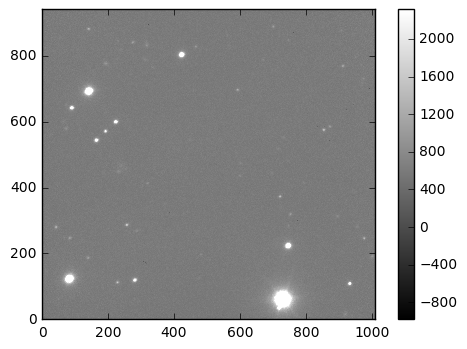

In [151]:
data = ccdu_list[0].data
m, s = np.mean(data), np.std(data)
pl.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
pl.colorbar();

In [152]:
bkg = sep.Background(data)


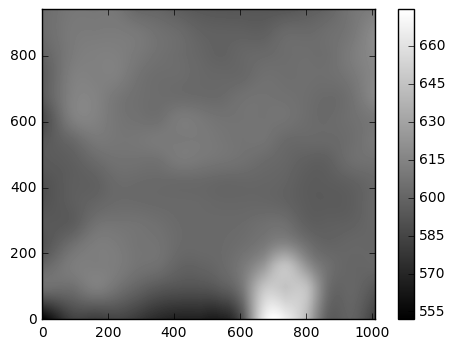

In [153]:
bkg_image = bkg.back()
pl.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
pl.colorbar();


In [155]:
data_sub = data - bkg


In [156]:
objects = sep.extract(data_sub, 3, err=bkg.globalrms)


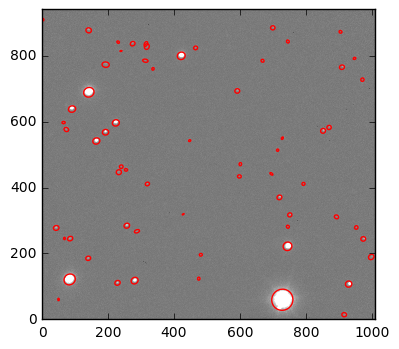

In [158]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = pl.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [160]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     5.0, err=bkg.globalrms, gain=1.0)

In [161]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))


object 0: flux = 12298.092501 +/- 309.692031
object 1: flux = 5313.843688 +/- 297.988464
object 2: flux = 33560.904722 +/- 342.241688
object 3: flux = 142220.922175 +/- 475.262640
object 4: flux = 7925977.222188 +/- 2830.144177
object 5: flux = 6972.886070 +/- 300.759318
object 6: flux = 180049.466714 +/- 513.437372
object 7: flux = 4268085.176563 +/- 2086.031127
object 8: flux = 20536.956427 +/- 322.785705
object 9: flux = 16995.053122 +/- 317.453128


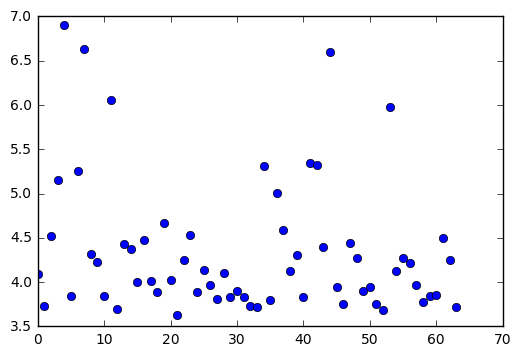

In [165]:
pl.plot(np.log10(flux), ls='', marker='o')